# Table of Contents: <a class="anchor" id="contents"></a> 

* [Importing and cleaning data](#import)
* [Descriptive Stats](#descr)
* [Logistic Regression RFE](#logisticrfe)
    * [HNHC](#lrhnhc)
    * [HNHC no 'los'](#lrhnhcnolos)
    * [IBD_READM](#lrreadm)
    * [IBD_READM no 'los'](#lrreadmnolos)
* [Decision Tree RFE](#decisiontreerfe)
    * [HNHC](#dthnhc)
    * [HNHC no 'los'](#dthnhcnolos)
    * [IBD_READM](#dtreadm)
    * [IBD_READM no 'los'](#dtreadmnolos)
* [XGBoost RFE](#xgboostrfe)
    * [HNHC](#xgbhnhc)
    * [HNHC no 'los'](#xgbhnhcnolos)
    * [IBD_READM](#xgbreadm)
    * [IBD_READM no 'los'](#xgbreadmnolos)

## Importing and cleaning data <a class="anchor" id="import"></a>

[Return to Table of Contents](#contents)

In [1]:
# Import dependencies
from sklearn import tree
import pandas as pd
import numpy as np
import os
import warnings
import timeit
import dask.dataframe as dd
from IPython.display import display 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [2]:
# Read in the data as a dataframe.
df = pd.read_csv('NRD 2013 (machine learning).csv')
df.head()

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [3]:
# Create a list of the column names and print it out.
variables = df.columns.values
print(variables)

['index' 'age' 'aweekend' 'died' 'discwt' 'dispuniform' 'dmonth' 'dqtr'
 'drg' 'drgver' 'drg_nopoa' 'dx1' 'dx2' 'dx3' 'dx4' 'dx5' 'dx6' 'dx7'
 'dx8' 'dx9' 'dx10' 'dx11' 'dx12' 'dx13' 'dx14' 'dx15' 'dx16' 'dx17'
 'dx18' 'dx19' 'dx20' 'dx21' 'dx22' 'dx23' 'dx24' 'dx25' 'dxccs1' 'dxccs2'
 'dxccs3' 'dxccs4' 'dxccs5' 'dxccs6' 'dxccs7' 'dxccs8' 'dxccs9' 'dxccs10'
 'dxccs11' 'dxccs12' 'dxccs13' 'dxccs14' 'dxccs15' 'dxccs16' 'dxccs17'
 'dxccs18' 'dxccs19' 'dxccs20' 'dxccs21' 'dxccs22' 'dxccs23' 'dxccs24'
 'dxccs25' 'elective' 'female' 'hcup_ed' 'hosp_nrd' 'key_nrd' 'los' 'mdc'
 'mdc_nopoa' 'nchronic' 'ndx' 'necode' 'npr' 'nrd_daystoevent'
 'nrd_stratum' 'nrd_visitlink' 'orproc' 'pay1' 'pl_nchs' 'pr1' 'pr2' 'pr3'
 'pr4' 'pr5' 'pr6' 'pr7' 'pr8' 'pr9' 'pr10' 'pr11' 'pr12' 'pr13' 'pr14'
 'pr15' 'prccs1' 'prccs2' 'prccs3' 'prccs4' 'prccs5' 'prccs6' 'prccs7'
 'prccs8' 'prccs9' 'prccs10' 'prccs11' 'prccs12' 'prccs13' 'prccs14'
 'prccs15' 'rehabtransfer' 'resident' 'samedayevent' 'totchg' 'year'
 'zip

In [4]:
# Look at the ibd_specific_adm column
df['ibd_specific_adm']

0        0
1        0
2        0
3        1
4        1
        ..
94493    1
94494    0
94495    0
94496    0
94497    1
Name: ibd_specific_adm, Length: 94498, dtype: int64

In [5]:
# Make a copy of the dataframe
df_copy = df.copy()
df_copy.head()

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [6]:
# Check the back end of the data
df_copy.tail()

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [7]:
# Check the data 
# Looks like the ibd_readm variables contains "NA" values

df_copy[['nrd_visitlink','ibd_index_hosp', 'dx1', 'new_mi_adm', 'ibd_readm']].head()

,nrd_visitlink,ibd_index_hosp,dx1,new_mi_adm,ibd_readm
0,00017u,1,00845,0,0
1,00017u,0,0389,0,1
2,00017u,0,03842,0,1
3,0004o5,1,5559,0,0
4,000dbz,1,5559,0,0


In [8]:
# Recoding the ibd_readm outcome variable
readm_set = set()
for index, row in df_copy[['nrd_visitlink','ibd_readm']].iterrows():
    if row[1] == 1:
        readm_set.add(row[0])
        
readm_list = list(readm_set)

df_copy.loc[df_copy.nrd_visitlink.isin(readm_list), 'ibd_readm'] = '1'
df_copy[['nrd_visitlink','ibd_index_hosp', 'ibd_readm']].head(15)

,nrd_visitlink,ibd_index_hosp,ibd_readm
0,00017u,1,1
1,00017u,0,1
2,00017u,0,1
3,0004o5,1,0
4,000dbz,1,1
5,000dbz,0,1
6,000dbz,0,1
7,000dbz,0,1
8,000dbz,0,1
9,000mgu,1,0


In [9]:
df_copy[['nrd_visitlink', 'pay1', 'ibd_index_hosp', 'ibd_readm']].head(15)

,nrd_visitlink,pay1,ibd_index_hosp,ibd_readm
0,00017u,1.0,1,1
1,00017u,1.0,0,1
2,00017u,1.0,0,1
3,0004o5,3.0,1,0
4,000dbz,1.0,1,1
5,000dbz,1.0,0,1
6,000dbz,1.0,0,1
7,000dbz,1.0,0,1
8,000dbz,1.0,0,1
9,000mgu,3.0,1,0


In [10]:
# Number of index hospitalizations
index_hosp_counts = df_copy['ibd_index_hosp'].value_counts()
index_hosp_counts

1    47402
0    47096
Name: ibd_index_hosp, dtype: int64

In [11]:
# Number of readmissions within six months
readm_counts = df_copy['ibd_readm'].value_counts()
readm_counts

1    64373
0    30125
Name: ibd_readm, dtype: int64

In [12]:
# Filter the data so that only patients with an index hospitalizations are in a DataFrame
readm_data_df = df_copy.loc[df_copy["ibd_index_hosp"] == 1, :]

# Check to ensure the filter worked correctly
readm_data_df["ibd_index_hosp"].count()

47402

In [13]:
# Creating deciles by length of follow-up normalized by number of hospitalizations 
readm_data_df['ibd_deciles'] = pd.qcut(readm_data_df['ibdtotlos_alive_fu'], 10, labels=np.arange(10, 0, -1))

readm_data_df.head(15)

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [14]:
# Check for null values
df_copy.isnull().sum()

index                              0
age                                0
aweekend                           0
died                              24
discwt                             0
dispuniform                       24
dmonth                             0
dqtr                               0
drg                                0
drgver                             0
drg_nopoa                          0
dx1                                6
dx2                              691
dx3                             2900
dx4                             6521
dx5                            11371
dx6                            17030
dx7                            23256
dx8                            29521
dx9                            35806
dx10                           44316
dx11                           49750
dx12                           54797
dx13                           59549
dx14                           63771
dx15                           67847
dx16                           74731
d

In [15]:
# Generate a new variable to identify high-need, high-cost patients

def topDecile(series):
    if series == 1:
        return 1
    else:
        return 0
        
readm_data_df['hnhc_patients'] = readm_data_df['ibd_deciles'].apply(topDecile)

readm_data_df.tail(25)

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [16]:
# Create new features using isin function

# steroid use - V5865
readm_data_df['steroid_use'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['V5865']).any(axis=1).astype(int)

# abdominal pain - 78900
readm_data_df['abd_pain_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['78900']).any(axis=1).astype(int)

# acute kidney injury - 5849
readm_data_df['aki_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['5849']).any(axis=1).astype(int)

# gi bleed - 5789
readm_data_df['gi_bleed_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['5789']).any(axis=1).astype(int)

readm_data_df.head(25)


,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [17]:
# Intially run with entire feature list so RFE can use backwards selection to pick top features
data = readm_data_df[['hnhc_patients', 'ibd_readm', 'steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm',
 'age',
 'female',
 'los',
 'aweekend',
 'elective',
 'orproc',
 'hosp_urban_rural_location',
 'payer',
 'zipinc_qrtl',
 'severe_IBD_hospitalization',
 'cm_aids',
 'cm_alcohol',
 'cm_anemdef',
 'cm_arth',
 'cm_bldloss',
 'cm_chf',
 'cm_chrnlung',
 'cm_depress',
 'cm_coag',
 'cm_dm',
 'cm_dmcx',
 'cm_drug',
 'cm_htn_c',
 'cm_hypothy',
 'cm_liver',
 'cm_lymph',
 'cm_lytes',
 'cm_mets',
 'cm_neuro',
 'cm_obese',
 'cm_para',
 'cm_perivasc',
 'cm_psych',
 'cm_pulmcirc',
 'cm_renlfail',
 'cm_tumor',
 'cm_ulcer',
 'cm_valve',
 'cm_wghtloss',
 'diabetes',
 'copd',
 'cm_smoking',
 'blood_transfusion',
 'ibd_procedures',
 'cc_index',
 'new_cc_index',
 'fractures',
 'thromboses',
 'unplanned_adm',
 'pq1_dm_short',
 'pq2_perf_appendix',
 'pq3_dm_long',
 'pq5_copd_asthma',
 'pq7_htn',
 'pq8_chf',
 'pq10_dehydrate',
 'pq11_bacterialpna',
 'pq12_uti',
 'pq13_angina',
 'pq14_diabeteswocomp',
 'pq15_asthma',
 'pq16_dm_amputate',
 'new_mi_adm',
 'new_chf_adm',
 'new_unstableangina_adm',
 'new_arrhythmia_adm',
 'new_cardiacarrest_adm',
 'new_meningitis_adm',
 'new_encephalitis_adm',
 'new_endocarditis_adm',
 'new_pneumonia_adm',
 'new_pyelonephritis_adm',
 'new_osteo_adm',
 'new_septicemia_adm',
 'new_cdiff_adm',
 'new_tb_adm',
 'new_atypicalmyco_adm',
 'new_fungal_adm',
 'new_listeriosis_adm',
 'new_leishmaniasis_adm',
 'new_pcp_adm',
 'chronic_pain',
 'ibd_surgery_adm',
 'frailty_risk_score',
 'frailty_risk_category_index',
 'h_contrl',
 'hosp_bedsize',
 'hosp_ur_teach',
 'hosp_urcat4',
 'prevent_readm',
 'cardiac_adm',
 'cvd_adm',
 'resp_adm',
 'infxn_adm',
 'gu_adm',
 'gi_adm',
 'endo_adm',
 'neuro_adm',
 'malignancies_adm',
 'fracture_adm',
 'thrombosis_adm',
 'ibd_specific_adm',
 'others_adm']]

cleaned_data = data.dropna(axis='rows')
cleaned_data

,hnhc_patients,ibd_readm,steroid_use,abd_pain_adm,aki_adm,gi_bleed_adm,age,female,los,aweekend,elective,orproc,hosp_urban_rural_location,payer,zipinc_qrtl,severe_IBD_hospitalization,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_depress,cm_coag,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,blood_transfusion,ibd_procedures,cc_index,new_cc_index,fractures,thromboses,unplanned_adm,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,frailty_risk_score,frailty_risk_category_index,h_contrl,hosp_bedsize,hosp_ur_teach,hosp_urcat4,prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm
0,0,1,0,0,0,0,89,0,4,1,0.0,0,0,1.0,4.0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,2,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.7,0.0,1,3,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,48,1,4,0,1.0,1,0,2.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0.0,1,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,1,0,0,0,0,65,0,5,0,0.0,0,0,1.0,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.7,1.0,2,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,51,0,3,0,0.0,1,0,2.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.8,0.0,2,2,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0
10,0,0,0,0,0,0,22,0,6,0,1.0,1,0,1.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.8,0.0,2,3,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94491,0,0,0,0,0,0,32,1,3,1,0.0,0,0,2.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
94492,0,0,0,0,0,0,54,0,4,0,1.0,1,0,2.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,2,3,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
94493,1,1,0,0,0,0,44,0,9,0,1.0,1,0,2.0,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
94496,0,0,0,0,0,0,52,1,2,0,1.0,1,0,1.0,1.0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,2,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.5,0.0,2,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Descriptive Stats <a class="anchor" id="descr"></a> 

[Return to Table of Contents](#contents)

In [18]:
display(cleaned_data.describe())

,hnhc_patients,steroid_use,abd_pain_adm,aki_adm,gi_bleed_adm,age,female,los,aweekend,elective,orproc,hosp_urban_rural_location,payer,zipinc_qrtl,severe_IBD_hospitalization,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_depress,cm_coag,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,blood_transfusion,ibd_procedures,cc_index,new_cc_index,fractures,thromboses,unplanned_adm,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,frailty_risk_score,frailty_risk_category_index,h_contrl,hosp_bedsize,hosp_ur_teach,hosp_urcat4,prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm
count,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.0,46586.000000,46586.000000,46586.0,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.0,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000,46586.000000
mean,0.099579,0.049285,0.015133,0.101297,0.016121,53.368995,0.571094,5.489954,0.204353,0.179281,0.250504,0.077727,1.621260,2.562401,0.182823,0.001138,0.027369,0.221354,0.046495,0.030524,0.051174,0.167969,0.137423,0.046087,0.126690,0.023526,0.039669,0.381037,0.102241,0.039840,0.005817,0.335358,0.013781,0.060984,0.086850,0.012235,0.038123,0.046194,0.016164,0.082428,0.014897,0.000623,0.029258,0.089490,0.174688,0.174688,0.263062,0.107243,0.296634,0.876594,0.611428,0.021272,0.069892,0.820719,0.002168,0.001803,0.002640,0.016829,0.001567,0.008479,0.013545,0.017065,0.008608,0.000580,0.000472,0.004594,0.000301,0.009595,0.038016,0.002683,0.052741,0.000837,0.000279,0.000172,0.000408,0.003198,0.002447,0.003048,0.054630,0.028549,0.000129,0.000301,0.000301,0.000086,0.0,0.000172,0.023333,0.0,4.224756,0.326708,2.035998,2.556197,0.668055,1.508951,0.074057,0.049521,0.0,0.051324,0.112137,0.028335,0.164835,0.018525,0.011720,0.019019,0.013609,0.005302,0.317628,0.014489
std,0.299441,0.216465,0.122084,0.301724,0.125941,19.353035,0.494925,7.409962,0.403233,0.383592,0.433308,0.267745,0.780099,1.103928,0.386526,0.033711,0.163157,0.415163,0.210556,0.172026,0.220355,0.373843,0.344297,0.209675,0.332629,0.151570,0.195181,0.485647,0.302968,0.195586,0.076049

In [19]:
# Removing correlated features
correlated_features = set()
correlation_matrix = cleaned_data.drop('hnhc_patients', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [20]:
# Drop these features
correlated_features

{'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'}

In [21]:
# Grab outcome/label names after dropping na's/rows with na's
target_hnhc = cleaned_data["hnhc_patients"]
target_names_hnhc = ["none", "hnhc"]
target_hnhc = target_hnhc.astype('int64')
target_hnhc

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 46586, dtype: int64

In [22]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features
cleaned_data_wo_outcome_hnhc = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_hnhc = cleaned_data_wo_outcome_hnhc.columns
featured_names_hnhc

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'los', 'aweekend', 'elective', 'orproc',
       ...
       'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm',
       'malignancies_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm'],
      dtype='object', length=101)

In [23]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features and drop 'los' for testing
cleaned_data_wo_outcome_hnhc_no_los = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_hnhc_no_los = cleaned_data_wo_outcome_hnhc_no_los.columns
featured_names_hnhc_no_los

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location',
       'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids',
       'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf',
       'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug',
       'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets',
       'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych',
       'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve',
       'cm_wghtloss', 'cm_smoking', 'blood_transfusion', 'ibd_procedures',
       'cc_index', 'fractures', 'thromboses', 'pq1_dm_short',
       'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn',
       'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti',
       'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate',
       'new_mi_adm', 'new_chf_adm', 'new_unstab

In [24]:
# Repeat the last two steps (above previous code block) for 'readmit' as target instead of 'hnhc'
target_readmit = cleaned_data["ibd_readm"]
target_names_readmit = ["none", "ibd_readm"]
target_readmit = target_readmit.astype('int64')
target_readmit

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 46586, dtype: int64

In [25]:
cleaned_data_wo_outcome_readmit = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_readmit = cleaned_data_wo_outcome_readmit.columns
featured_names_readmit

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'los', 'aweekend', 'elective', 'orproc',
       ...
       'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm',
       'malignancies_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm'],
      dtype='object', length=101)

In [26]:
cleaned_data_wo_outcome_readmit_no_los = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_readmit_no_los = cleaned_data_wo_outcome_readmit_no_los.columns
featured_names_readmit_no_los

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location',
       'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids',
       'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf',
       'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug',
       'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets',
       'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych',
       'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve',
       'cm_wghtloss', 'cm_smoking', 'blood_transfusion', 'ibd_procedures',
       'cc_index', 'fractures', 'thromboses', 'pq1_dm_short',
       'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn',
       'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti',
       'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate',
       'new_mi_adm', 'new_chf_adm', 'new_unstab

In [27]:
# Make sure the cleaned data also has the correlated features removed
cleaned_data_hnhc = cleaned_data.drop(['copd', 'ibd_readm',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_hnhc_no_los = cleaned_data.drop(['copd', 'ibd_readm', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_readmit = cleaned_data.drop(['copd', 'hnhc_patients',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_readmit_no_los = cleaned_data.drop(['copd', 'hnhc_patients', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

In [28]:
# Check for na values
cleaned_data_wo_outcome_hnhc.isnull().sum()

steroid_use                   0
abd_pain_adm                  0
aki_adm                       0
gi_bleed_adm                  0
age                           0
female                        0
los                           0
aweekend                      0
elective                      0
orproc                        0
hosp_urban_rural_location     0
payer                         0
zipinc_qrtl                   0
severe_IBD_hospitalization    0
cm_aids                       0
cm_alcohol                    0
cm_anemdef                    0
cm_arth                       0
cm_bldloss                    0
cm_chf                        0
cm_chrnlung                   0
cm_depress                    0
cm_coag                       0
cm_dm                         0
cm_dmcx                       0
cm_drug                       0
cm_htn_c                      0
cm_hypothy                    0
cm_liver                      0
cm_lymph                      0
cm_lytes                      0
cm_mets 

# Utilizing RFE to do feature selection

## Logistic Regression RFE <a class="anchor" id="logisticrfe"></a> 

[Return to Table of Contents](#contents)

## Target: HNHC <a class="anchor" id="lrhnhc"></a>

[Return to Table of Contents](#contents)

In [29]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['cm_drug' 'cm_lymph' 'cm_para' 'cm_renlfail' 'cm_ulcer' 'thromboses'
 'new_unstableangina_adm' 'new_osteo_adm' 'new_septicemia_adm' 'neuro_adm']


In [30]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,hnhc_patients,cm_drug,cm_lymph,cm_para,cm_renlfail,cm_ulcer,thromboses,new_unstableangina_adm,new_osteo_adm,new_septicemia_adm,neuro_adm
0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,0,0,0,0,0,0,0,0,0,0
94492,0,0,0,0,0,0,0,0,0,0,0
94493,1,0,0,0,0,0,0,0,0,0,0
94496,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47402, dtype: int64

In [32]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['cm_drug', 'cm_lymph', 'cm_para', 'cm_renlfail', 'cm_ulcer',
       'thromboses', 'new_unstableangina_adm', 'new_osteo_adm',
       'new_septicemia_adm', 'neuro_adm'],
      dtype='object')

In [33]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.8995527551967596
Testing Score: 0.9032992996371614


In [34]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

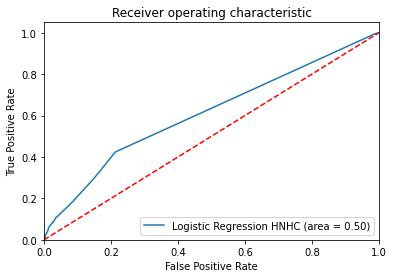

In [35]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression HNHC (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_HNHC_ROC_10')
plt.show()

In [36]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.12065673, 0.11730409, 0.11857748, 0.10429096, 0.12777066,
       0.12162018, 0.10025024, 0.11011791, 0.11239552, 0.1041913 ]), 'score_time': array([0.00774264, 0.00708294, 0.01036835, 0.01562238, 0.00877094,
       0.00839186, 0.01687789, 0.00722766, 0.00778604, 0.00726748]), 'test_roc_auc': array([0.60059688, 0.59140939, 0.61189268, 0.60976332, 0.57725771,
       0.60686594, 0.57881376, 0.60759714, 0.60528192, 0.60921789]), 'train_roc_auc': array([0.60069042, 0.60244199, 0.59945686, 0.5997039 , 0.60357501,
       0.600215  , 0.60317415, 0.60028813, 0.6009986 , 0.59993785]), 'test_precision': array([0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. , 0. , 0. ]), 'train_precision': array([0.5       , 0.6       , 0.5       , 0.5       , 0.42857143,
       0.5       , 0.4       , 0.28571429, 0.5       , 0.5       ]), 'test_recall': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00211864, 0.00211864, 0.00211864, 0.        , 0.        ]), 'train_recall

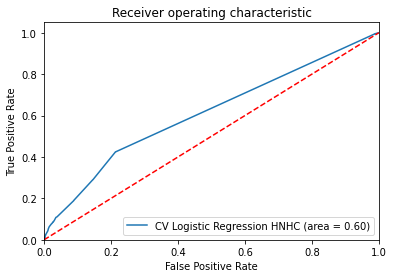

In [37]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression HNHC (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_HNHC_ROC_10')
plt.show()

In [38]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(-0.8415447658259606, 'new_unstableangina_adm'),
 (-0.6379119074424503, 'neuro_adm'),
 (0.5674445941719074, 'cm_drug'),
 (0.6182864882488412, 'new_septicemia_adm'),
 (0.7096402934409954, 'cm_renlfail'),
 (0.7374198438160163, 'thromboses'),
 (0.7561922004367532, 'cm_lymph'),
 (0.7980508242239883, 'cm_para'),
 (0.8547802127618064, 'new_osteo_adm'),
 (1.1650535247345086, 'cm_ulcer')]

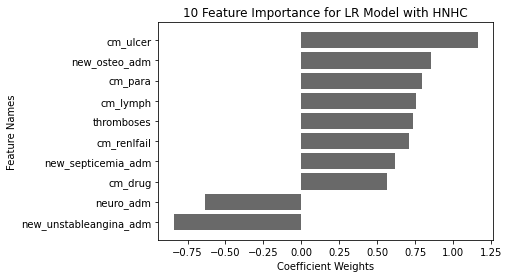

In [39]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for LR Model with HNHC')
plt.savefig('images\Logistic_Regression_HNHC_Feature_Importance_10')
plt.show()

## Target: HNHC without 'los' <a class="anchor" id="lrhnhcnolos"></a> 

[Return to Table of Contents](#contents)

In [40]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc_no_los, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['severe_IBD_hospitalization' 'cm_dmcx' 'cm_lymph' 'cm_para' 'cm_ulcer'
 'pq1_dm_short' 'pq2_perf_appendix' 'new_unstableangina_adm'
 'new_meningitis_adm' 'new_atypicalmyco_adm']


In [41]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,hnhc_patients,severe_IBD_hospitalization,cm_dmcx,cm_lymph,cm_para,cm_ulcer,pq1_dm_short,pq2_perf_appendix,new_unstableangina_adm,new_meningitis_adm,new_atypicalmyco_adm
0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,0,0,0,0,0,0,0,0,0,0
94492,0,0,0,0,0,0,0,0,0,0,0
94493,1,1,0,0,0,0,0,0,0,0,0
94496,0,0,0,0,0,0,0,0,0,0,0


In [42]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47402, dtype: int64

In [43]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['severe_IBD_hospitalization', 'cm_dmcx', 'cm_lymph', 'cm_para',
       'cm_ulcer', 'pq1_dm_short', 'pq2_perf_appendix',
       'new_unstableangina_adm', 'new_meningitis_adm', 'new_atypicalmyco_adm'],
      dtype='object')

In [44]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.8993839835728953
Testing Score: 0.9031305375073834


In [45]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

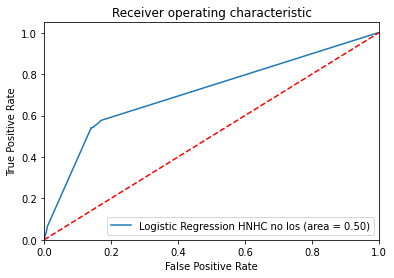

In [46]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression HNHC no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_HNHC_no_los_ROC_10')
plt.show()

In [47]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.17054486, 0.18849707, 0.14657688, 0.14585161, 0.18442011,
       0.1609714 , 0.16211629, 0.12270904, 0.14440084, 0.13885951]), 'score_time': array([0.0079782 , 0.00701451, 0.00698018, 0.        , 0.00762415,
       0.01746607, 0.        , 0.00682974, 0.01562691, 0.00769258]), 'test_roc_auc': array([0.71413392, 0.68564017, 0.70514035, 0.73548005, 0.72025524,
       0.72626305, 0.73120547, 0.69586313, 0.71177729, 0.72329431]), 'train_roc_auc': array([0.71522209, 0.71824428, 0.71620069, 0.71281208, 0.71450253,
       0.71370309, 0.71315663, 0.71705744, 0.71545845, 0.71420415]), 'test_precision': array([0.66666667, 0.5       , 0.5       , 0.6       , 0.        ,
       0.        , 0.5       , 0.5       , 0.33333333, 0.        ]), 'train_precision': array([0.35483871, 0.45454545, 0.38709677, 0.34482759, 0.5       ,
       0.46153846, 0.42307692, 0.42307692, 0.45454545, 0.43333333]), 'test_recall': array([0.00423729, 0.00847458, 0.00212314, 0.00636943, 0.        ,
     

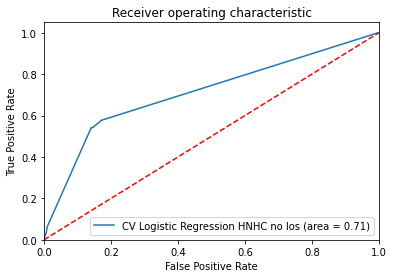

In [48]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression HNHC no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_HNHC_no_los_ROC_10')
plt.show()

In [49]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(-1.2211982633694636, 'pq2_perf_appendix'),
 (-0.7791040316028869, 'new_meningitis_adm'),
 (-0.7556748076874421, 'new_unstableangina_adm'),
 (0.4731956438829864, 'cm_para'),
 (0.6609804280078875, 'cm_ulcer'),
 (0.663039739439487, 'cm_dmcx'),
 (0.7277986215023237, 'new_atypicalmyco_adm'),
 (0.8255288537482969, 'cm_lymph'),
 (1.1355638070909189, 'pq1_dm_short'),
 (1.9864278354254823, 'severe_IBD_hospitalization')]

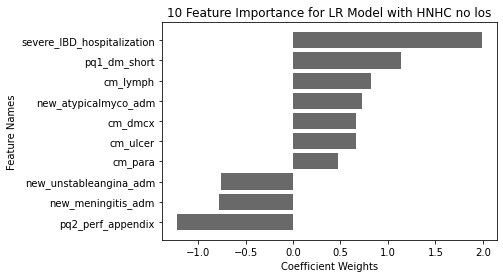

In [50]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for LR Model with HNHC no los')
plt.savefig('images\Logistic_Regression_HNHC_no_los_Feature_Importance_10')
plt.show()

## Target: IBD_READM <a class="anchor" id="lrreadm"></a>

[Return to Table of Contents](#contents)

In [51]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['cm_dmcx' 'pq16_dm_amputate' 'new_cardiacarrest_adm' 'new_meningitis_adm'
 'new_encephalitis_adm' 'new_tb_adm' 'new_atypicalmyco_adm'
 'new_fungal_adm' 'new_listeriosis_adm' 'chronic_pain']


In [52]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,ibd_readm,cm_dmcx,pq16_dm_amputate,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,chronic_pain
0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,0,0,0,0,0,0,0,0,0,0
94492,0,0,0,0,0,0,0,0,0,0,0
94493,1,0,0,0,0,0,0,0,0,0,0
94496,0,0,0,0,0,0,0,0,0,0,0


In [53]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47402, dtype: int64

In [54]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['cm_dmcx', 'pq16_dm_amputate', 'new_cardiacarrest_adm',
       'new_meningitis_adm', 'new_encephalitis_adm', 'new_tb_adm',
       'new_atypicalmyco_adm', 'new_fungal_adm', 'new_listeriosis_adm',
       'chronic_pain'],
      dtype='object')

In [55]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.590363140277348
Testing Score: 0.5997806092312885


In [56]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

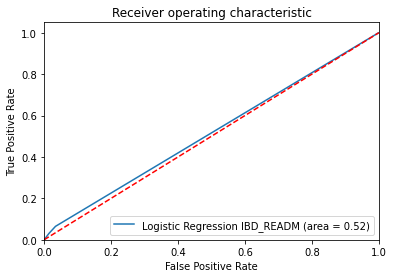

In [57]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression IBD_READM (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_IBD_READM_ROC_10')
plt.show()

In [58]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.11626577, 0.09178448, 0.11777091, 0.09731865, 0.11721921,
       0.09456921, 0.09303331, 0.09717131, 0.10126376, 0.09166098]), 'score_time': array([0.00897598, 0.00794172, 0.00811601, 0.        , 0.        ,
       0.00809932, 0.00813246, 0.00777984, 0.00698304, 0.00801206]), 'test_roc_auc': array([0.51396039, 0.52260759, 0.51486338, 0.51627645, 0.51633245,
       0.514597  , 0.51293685, 0.51483102, 0.51563453, 0.51801021]), 'train_roc_auc': array([0.51624716, 0.51528535, 0.51614401, 0.51598921, 0.51598266,
       0.51617527, 0.51639768, 0.51614837, 0.51605186, 0.51579483]), 'test_precision': array([0.55980861, 0.63157895, 0.56422018, 0.5787037 , 0.56198347,
       0.55656109, 0.54148472, 0.5473251 , 0.57711443, 0.60189573]), 'train_precision': array([0.57320717, 0.56510809, 0.5725    , 0.57121439, 0.57316456,
       0.57364729, 0.57545272, 0.57497467, 0.57142857, 0.56879362]), 'test_recall': array([0.05960265, 0.07335711, 0.0626592 , 0.06367804, 0.06931702,
     

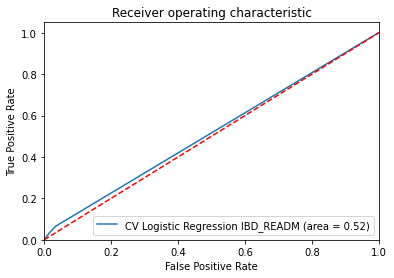

In [59]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression IBD_READM (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_IBD_READM_ROC_10')
plt.show()

In [60]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(-1.7283556230407615, 'new_cardiacarrest_adm'),
 (-1.0305877485799528, 'new_meningitis_adm'),
 (-0.635128259163299, 'new_listeriosis_adm'),
 (-0.4070032401623493, 'new_tb_adm'),
 (0.5076309344833683, 'new_fungal_adm'),
 (0.5419838672821156, 'cm_dmcx'),
 (0.6257741004840951, 'new_encephalitis_adm'),
 (0.7169792061174434, 'chronic_pain'),
 (0.8503696407439406, 'new_atypicalmyco_adm'),
 (0.8651066337194165, 'pq16_dm_amputate')]

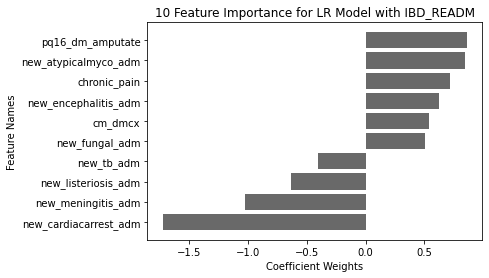

In [61]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for LR Model with IBD_READM')
plt.savefig('images\Logistic_Regression_IBD_READM_Feature_Importance_10')
plt.show()

## Target: IBD_READM no 'los' <a class="anchor" id="lrreadmnolos"></a>

[Return to Table of Contents](#contents)

In [62]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit_no_los, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['cm_dmcx' 'pq16_dm_amputate' 'new_cardiacarrest_adm' 'new_meningitis_adm'
 'new_encephalitis_adm' 'new_tb_adm' 'new_atypicalmyco_adm'
 'new_fungal_adm' 'new_listeriosis_adm' 'chronic_pain']


In [63]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,ibd_readm,cm_dmcx,pq16_dm_amputate,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,chronic_pain
0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,0,0,0,0,0,0,0,0,0,0
94492,0,0,0,0,0,0,0,0,0,0,0
94493,1,0,0,0,0,0,0,0,0,0,0
94496,0,0,0,0,0,0,0,0,0,0,0


In [64]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47402, dtype: int64

In [65]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['cm_dmcx', 'pq16_dm_amputate', 'new_cardiacarrest_adm',
       'new_meningitis_adm', 'new_encephalitis_adm', 'new_tb_adm',
       'new_atypicalmyco_adm', 'new_fungal_adm', 'new_listeriosis_adm',
       'chronic_pain'],
      dtype='object')

In [66]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.590363140277348
Testing Score: 0.5997806092312885


In [67]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

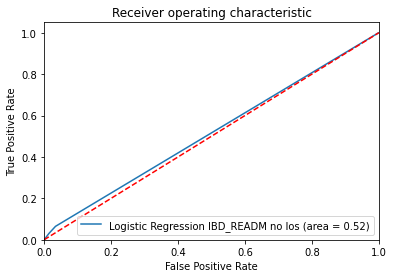

In [68]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression IBD_READM no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_IBD_READM_no_los_ROC_10')
plt.show()

In [69]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.11468434, 0.0957284 , 0.11070538, 0.09802723, 0.10599041,
       0.09290743, 0.0914185 , 0.08758903, 0.10020852, 0.08265471]), 'score_time': array([0.00897527, 0.00797868, 0.00897431, 0.00745368, 0.00732589,
       0.00928187, 0.00755692, 0.        , 0.0079782 , 0.01562142]), 'test_roc_auc': array([0.51396039, 0.52260759, 0.51486338, 0.51627645, 0.51633245,
       0.514597  , 0.51293685, 0.51483102, 0.51563453, 0.51801021]), 'train_roc_auc': array([0.51624716, 0.51528535, 0.51614401, 0.51598921, 0.51598266,
       0.51617527, 0.51639768, 0.51614837, 0.51605186, 0.51579483]), 'test_precision': array([0.55980861, 0.63157895, 0.56422018, 0.5787037 , 0.56198347,
       0.55656109, 0.54148472, 0.5473251 , 0.57711443, 0.60189573]), 'train_precision': array([0.57320717, 0.56510809, 0.5725    , 0.57121439, 0.57316456,
       0.57364729, 0.57545272, 0.57497467, 0.57142857, 0.56879362]), 'test_recall': array([0.05960265, 0.07335711, 0.0626592 , 0.06367804, 0.06931702,
     

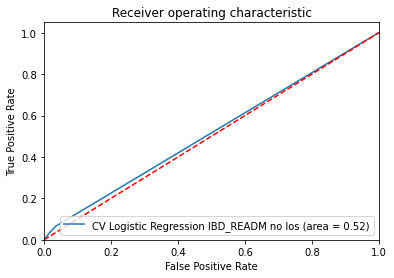

In [70]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression IBD_READM no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_IBD_READM_no_los_ROC_10')
plt.show()

In [71]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(-1.7283556230407615, 'new_cardiacarrest_adm'),
 (-1.0305877485799528, 'new_meningitis_adm'),
 (-0.635128259163299, 'new_listeriosis_adm'),
 (-0.4070032401623493, 'new_tb_adm'),
 (0.5076309344833683, 'new_fungal_adm'),
 (0.5419838672821156, 'cm_dmcx'),
 (0.6257741004840951, 'new_encephalitis_adm'),
 (0.7169792061174434, 'chronic_pain'),
 (0.8503696407439406, 'new_atypicalmyco_adm'),
 (0.8651066337194165, 'pq16_dm_amputate')]

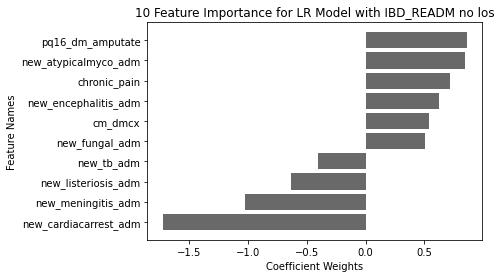

In [72]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for LR Model with IBD_READM no los')
plt.savefig('images\Logistic_Regression_IBD_READM_no_los_Feature_Importance_10')
plt.show()

## Decision Tree Classifier RFE <a class="anchor" id="decisiontreerfe"></a> 

## Target: HNHC <a class="anchor" id="dthnhc"></a>

[Return to Table of Contents](#contents)

In [73]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=10)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_hnhc, target_hnhc)
columns_retained_RFE_5 = cleaned_data_hnhc.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'female' 'los' 'zipinc_qrtl' 'cc_index' 'frailty_risk_score'
 'h_contrl' 'hosp_bedsize' 'hosp_ur_teach' 'hosp_urcat4']


In [74]:
# Feature list from RFE results
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

,hnhc_patients,age,female,los,zipinc_qrtl,cc_index,frailty_risk_score,h_contrl,hosp_bedsize,hosp_ur_teach,hosp_urcat4
0,0,89,0,4,4.0,2,4.7,1,3,1,1
3,0,48,1,4,3.0,0,0.5,1,3,1,2
4,1,65,0,5,2.0,0,5.7,2,2,1,2
9,0,51,0,3,4.0,0,2.8,2,2,1,2
10,0,22,0,6,2.0,0,3.8,2,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,32,1,3,4.0,0,0.0,2,2,1,1
94492,0,54,0,4,4.0,0,0.0,2,3,1,1
94493,1,44,0,9,4.0,0,0.0,2,3,1,1
94496,0,52,1,2,1.0,2,1.5,2,3,0,2


In [75]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["hnhc_patients"]
target_names_selected = ["none", "hnhc"]
target_selected = target_selected.astype('int64')
target_selected

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 46685, dtype: int64

In [76]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('hnhc_patients', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'female', 'los', 'zipinc_qrtl', 'cc_index', 'frailty_risk_score',
       'h_contrl', 'hosp_bedsize', 'hosp_ur_teach', 'hosp_urcat4'],
      dtype='object')

In [77]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 0.9992859794933311
Testing Score: 0.8496401644962303


In [78]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

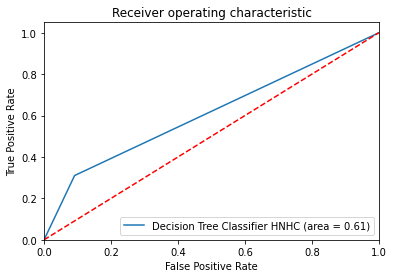

In [79]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier HNHC (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_HNHC_ROC_10')
plt.show()

In [80]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.04159379, 0.05676985, 0.04353619, 0.04384089, 0.04288292,
       0.0318985 , 0.04142022, 0.03748846, 0.04138541, 0.03749537]), 'score_time': array([0.00697351, 0.0099647 , 0.00699902, 0.00794458, 0.00769162,
       0.013767  , 0.00914717, 0.0082705 , 0.        , 0.00794625]), 'test_roc_auc': array([0.78505136, 0.76498598, 0.76739127, 0.8058173 , 0.76650809,
       0.78797492, 0.78210279, 0.77966592, 0.78297096, 0.78420721]), 'train_roc_auc': array([0.78859553, 0.79156565, 0.78752884, 0.78618899, 0.79007543,
       0.78817498, 0.78871432, 0.78601332, 0.78881308, 0.78701408]), 'test_precision': array([0.80508475, 0.76923077, 0.76510067, 0.84732824, 0.78512397,
       0.77777778, 0.74509804, 0.80952381, 0.74404762, 0.76865672]), 'train_precision': array([0.82402707, 0.8470483 , 0.79039634, 0.84432234, 0.82964225,
       0.79176201, 0.77194245, 0.77542063, 0.78299776, 0.83549784]), 'test_recall': array([0.20430108, 0.17204301, 0.24516129, 0.23870968, 0.20430108,
     

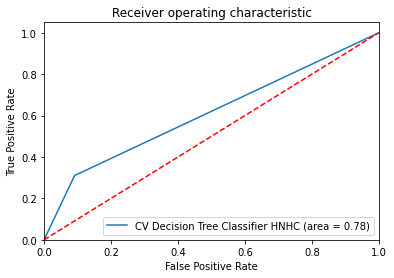

In [81]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier HNHC (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_HNHC_ROC_10')
plt.show()

In [82]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.028154399215122274, 'hosp_urcat4'),
 (0.030867784643554982, 'hosp_ur_teach'),
 (0.035797202784641956, 'h_contrl'),
 (0.03870404220712584, 'female'),
 (0.043943314553623984, 'hosp_bedsize'),
 (0.04875649800542347, 'cc_index'),
 (0.06768629086703554, 'zipinc_qrtl'),
 (0.20037919086685815, 'age'),
 (0.22408011660604757, 'frailty_risk_score'),
 (0.2816311602505662, 'los')]

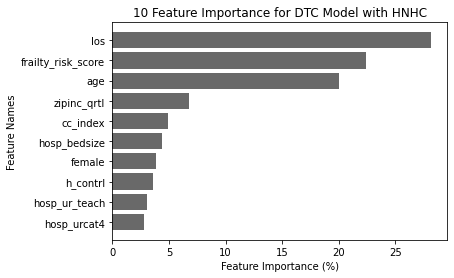

In [83]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for DTC Model with HNHC')
plt.savefig('images\Decision_Tree_Classifier_HNHC_Feature_Importance_10')
plt.show()

## Target: HNHC without 'los' <a class="anchor" id="dthnhcnolos"></a>

[Return to Table of Contents](#contents)

In [84]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=10)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_hnhc_no_los, target_hnhc)
columns_retained_RFE_5 = cleaned_data_hnhc_no_los.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'female' 'zipinc_qrtl' 'severe_IBD_hospitalization' 'cc_index'
 'frailty_risk_score' 'h_contrl' 'hosp_bedsize' 'hosp_ur_teach'
 'hosp_urcat4']


In [85]:
# Feature list from RFE results
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

,hnhc_patients,age,female,zipinc_qrtl,severe_IBD_hospitalization,cc_index,frailty_risk_score,h_contrl,hosp_bedsize,hosp_ur_teach,hosp_urcat4
0,0,89,0,4.0,0,2,4.7,1,3,1,1
3,0,48,1,3.0,0,0,0.5,1,3,1,2
4,1,65,0,2.0,0,0,5.7,2,2,1,2
9,0,51,0,4.0,0,0,2.8,2,2,1,2
10,0,22,0,2.0,0,0,3.8,2,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,32,1,4.0,0,0,0.0,2,2,1,1
94492,0,54,0,4.0,0,0,0.0,2,3,1,1
94493,1,44,0,4.0,1,0,0.0,2,3,1,1
94496,0,52,1,1.0,0,2,1.5,2,3,0,2


In [86]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["hnhc_patients"]
target_names_selected = ["none", "hnhc"]
target_selected = target_selected.astype('int64')
target_selected

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 46685, dtype: int64

In [87]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('hnhc_patients', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'female', 'zipinc_qrtl', 'severe_IBD_hospitalization',
       'cc_index', 'frailty_risk_score', 'h_contrl', 'hosp_bedsize',
       'hosp_ur_teach', 'hosp_urcat4'],
      dtype='object')

In [88]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 0.9970867963327906
Testing Score: 0.8348183687457162


In [89]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

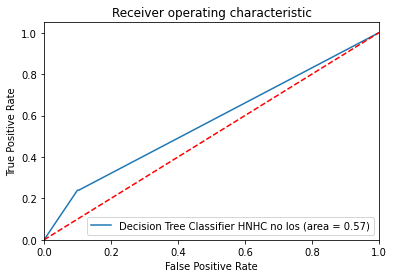

In [90]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier HNHC no los (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_HNHC_no_los_ROC_10')
plt.show()

In [91]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.03693271, 0.04387164, 0.03590059, 0.03989053, 0.03590751,
       0.03691196, 0.03490615, 0.03489447, 0.03490615, 0.03387713]), 'score_time': array([0.00797963, 0.00797892, 0.00695062, 0.00797892, 0.00994039,
       0.00698018, 0.00698423, 0.00797701, 0.00700283, 0.00752211]), 'test_roc_auc': array([0.75985441, 0.72965737, 0.74660871, 0.76473226, 0.73636936,
       0.76147922, 0.75888214, 0.76173067, 0.75467304, 0.76573163]), 'train_roc_auc': array([0.76428807, 0.76672666, 0.76516063, 0.76205678, 0.76419942,
       0.76346171, 0.76417542, 0.76319052, 0.76443236, 0.76190205]), 'test_precision': array([0.71428571, 0.5       , 0.47058824, 0.47058824, 0.35294118,
       0.58333333, 0.36363636, 0.6875    , 0.81481481, 0.43055556]), 'train_precision': array([0.61842105, 0.64335664, 0.64189189, 0.64383562, 0.57711443,
       0.62913907, 0.64473684, 0.61904762, 0.58992806, 0.52647504]), 'test_recall': array([0.02150538, 0.02150538, 0.0172043 , 0.0172043 , 0.01290323,
     

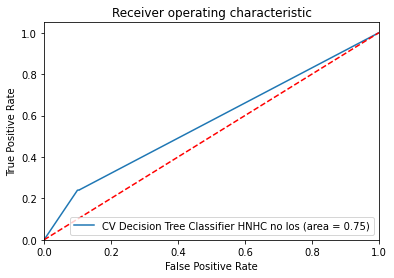

In [92]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier HNHC no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_HNHC_no_los_ROC_10')
plt.show()

In [93]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.043013978143431005, 'female'),
 (0.04777624707733626, 'hosp_urcat4'),
 (0.048140075981918384, 'hosp_ur_teach'),
 (0.050141222501376474, 'h_contrl'),
 (0.0572698061688332, 'cc_index'),
 (0.057853739478900754, 'hosp_bedsize'),
 (0.07478197387600524, 'zipinc_qrtl'),
 (0.0999159408437212, 'severe_IBD_hospitalization'),
 (0.23906087123032846, 'age'),
 (0.28204614469814915, 'frailty_risk_score')]

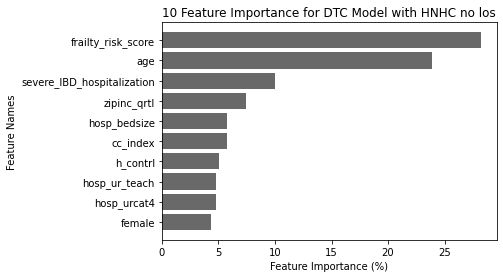

In [94]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for DTC Model with HNHC no los')
plt.savefig('images\Decision_Tree_Classifier_HNHC_no_los_Feature_Importance_10')
plt.show()

## Target: IBD_READM <a class="anchor" id="dtreadm"></a>

[Return to Table of Contents](#contents)

In [95]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=10)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_readmit, target_readmit)
columns_retained_RFE_5 = cleaned_data_readmit.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'female' 'los' 'zipinc_qrtl' 'cm_htn_c' 'frailty_risk_score'
 'h_contrl' 'hosp_bedsize' 'hosp_ur_teach' 'hosp_urcat4']


In [96]:
# Feature list from RFE results
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

,ibd_readm,age,female,los,zipinc_qrtl,cm_htn_c,frailty_risk_score,h_contrl,hosp_bedsize,hosp_ur_teach,hosp_urcat4
0,1,89,0,4,4.0,1,4.7,1,3,1,1
3,0,48,1,4,3.0,0,0.5,1,3,1,2
4,1,65,0,5,2.0,1,5.7,2,2,1,2
9,0,51,0,3,4.0,0,2.8,2,2,1,2
10,0,22,0,6,2.0,0,3.8,2,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,32,1,3,4.0,0,0.0,2,2,1,1
94492,0,54,0,4,4.0,0,0.0,2,3,1,1
94493,1,44,0,9,4.0,0,0.0,2,3,1,1
94496,0,52,1,2,1.0,1,1.5,2,3,0,2


In [97]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["ibd_readm"]
target_names_selected = ["none", "ibd_readm"]
target_selected = target_selected.astype('int64')
target_selected

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 46685, dtype: int64

In [98]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('ibd_readm', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'female', 'los', 'zipinc_qrtl', 'cm_htn_c', 'frailty_risk_score',
       'h_contrl', 'hosp_bedsize', 'hosp_ur_teach', 'hosp_urcat4'],
      dtype='object')

In [99]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 0.9934881329791792
Testing Score: 0.5194482522275531


In [100]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

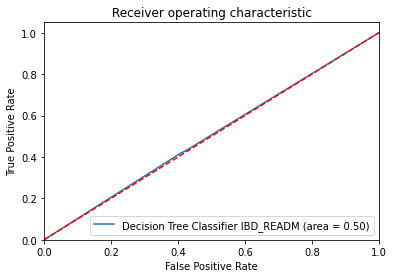

In [101]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier IBD_READM (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_ROC_10')
plt.show()

In [102]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.0478723 , 0.0379014 , 0.04491496, 0.04192305, 0.05012035,
       0.03955412, 0.04081392, 0.04146647, 0.03925419, 0.03191257]), 'score_time': array([0.00797844, 0.00794578, 0.00893974, 0.00997543, 0.00897479,
       0.00857329, 0.00210953, 0.01021957, 0.00897932, 0.00921607]), 'test_roc_auc': array([0.58850043, 0.58182148, 0.5716486 , 0.58726373, 0.58102614,
       0.57895003, 0.57318425, 0.59583234, 0.59737525, 0.56801022]), 'train_roc_auc': array([0.59419371, 0.59381372, 0.59633173, 0.59417028, 0.59330832,
       0.5948927 , 0.59608437, 0.59260937, 0.59446937, 0.59583556]), 'test_precision': array([0.53368794, 0.5       , 0.49931224, 0.52827918, 0.528     ,
       0.52036199, 0.52951096, 0.55306428, 0.52995392, 0.53354633]), 'train_precision': array([0.54180939, 0.53005764, 0.53539823, 0.52088321, 0.53338346,
       0.52014188, 0.53644584, 0.53518579, 0.53462648, 0.53895877]), 'test_recall': array([0.1557971 , 0.2184265 , 0.1878882 , 0.22722567, 0.20507509,
     

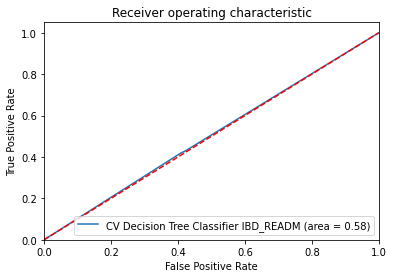

In [103]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier IBD_READM (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_IBD_READM_ROC_10')
plt.show()

In [104]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.039798965475152465, 'cm_htn_c'),
 (0.0403138577185264, 'female'),
 (0.047446939352496394, 'hosp_ur_teach'),
 (0.04821641011504694, 'hosp_urcat4'),
 (0.058677861895598, 'h_contrl'),
 (0.0661287279313905, 'hosp_bedsize'),
 (0.07474705276347185, 'zipinc_qrtl'),
 (0.11323411802669855, 'los'),
 (0.2223272650089854, 'frailty_risk_score'),
 (0.2891088017126335, 'age')]

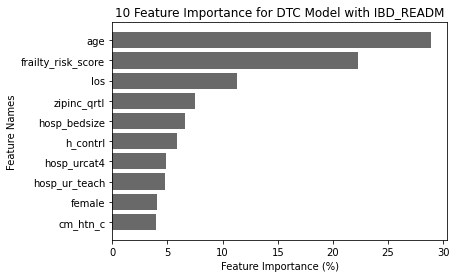

In [105]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for DTC Model with IBD_READM')
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_Feature_Importance_10')
plt.show()

## Target: IBD_READM no 'los' <a class="anchor" id="dtreadmnolos"></a>

[Return to Table of Contents](#contents)

In [106]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=10)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_readmit_no_los, target_readmit)
columns_retained_RFE_5 = cleaned_data_readmit_no_los.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'aweekend' 'zipinc_qrtl' 'cm_htn_c' 'frailty_risk_score' 'h_contrl'
 'hosp_bedsize' 'hosp_ur_teach' 'hosp_urcat4' 'gi_adm']


In [107]:
# Feature list from RFE results
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

,ibd_readm,age,aweekend,zipinc_qrtl,cm_htn_c,frailty_risk_score,h_contrl,hosp_bedsize,hosp_ur_teach,hosp_urcat4,gi_adm
0,1,89,1,4.0,1,4.7,1,3,1,1,0
3,0,48,0,3.0,0,0.5,1,3,1,2,0
4,1,65,0,2.0,1,5.7,2,2,1,2,0
9,0,51,0,4.0,0,2.8,2,2,1,2,1
10,0,22,0,2.0,0,3.8,2,3,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,32,1,4.0,0,0.0,2,2,1,1,0
94492,0,54,0,4.0,0,0.0,2,3,1,1,1
94493,1,44,0,4.0,0,0.0,2,3,1,1,0
94496,0,52,0,1.0,1,1.5,2,3,0,2,0


In [108]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["ibd_readm"]
target_names_selected = ["none", "ibd_readm"]
target_selected = target_selected.astype('int64')
target_selected

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 46685, dtype: int64

In [109]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('ibd_readm', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'aweekend', 'zipinc_qrtl', 'cm_htn_c', 'frailty_risk_score',
       'h_contrl', 'hosp_bedsize', 'hosp_ur_teach', 'hosp_urcat4', 'gi_adm'],
      dtype='object')

In [110]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 0.9759517893353897
Testing Score: 0.513279643591501


In [111]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

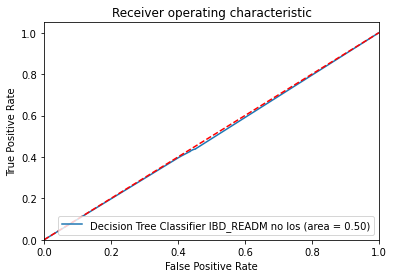

In [112]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier IBD_READM no los (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_no_los_ROC_10')
plt.show()

In [113]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.03951859, 0.03381467, 0.03828335, 0.03721595, 0.03394222,
       0.03391266, 0.03490639, 0.03489995, 0.03390884, 0.03291082]), 'score_time': array([0.00897646, 0.00832558, 0.0079093 , 0.00797462, 0.00897121,
       0.00794482, 0.00698662, 0.0079782 , 0.00794792, 0.00800729]), 'test_roc_auc': array([0.56384737, 0.55973751, 0.5504248 , 0.57178836, 0.55843776,
       0.55468353, 0.54893071, 0.57248956, 0.57057987, 0.54816971]), 'train_roc_auc': array([0.57480257, 0.57530497, 0.57592904, 0.57296824, 0.57557137,
       0.57414282, 0.5756783 , 0.57230039, 0.57369749, 0.5756088 ]), 'test_precision': array([0.47752809, 0.47560976, 0.48027842, 0.47142857, 0.45098039,
       0.43396226, 0.48      , 0.51441242, 0.54452926, 0.48561151]), 'train_precision': array([0.51850719, 0.5200199 , 0.51586515, 0.51360726, 0.54933333,
       0.54512635, 0.51856799, 0.50333087, 0.51367089, 0.5294378 ]), 'test_recall': array([0.08799172, 0.12111801, 0.10714286, 0.10248447, 0.01191093,
     

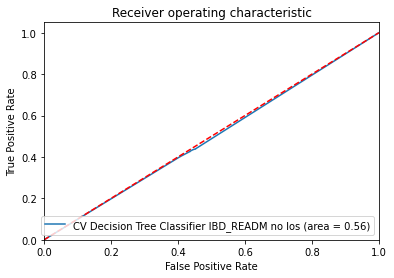

In [114]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier IBD_READM no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_IBD_READM_no_los_ROC_10')
plt.show()

In [115]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.035415309125813824, 'aweekend'),
 (0.0400022113319236, 'gi_adm'),
 (0.04710763706083599, 'hosp_urcat4'),
 (0.04964342842693944, 'cm_htn_c'),
 (0.05200915579232886, 'hosp_ur_teach'),
 (0.05402940427386031, 'hosp_bedsize'),
 (0.060566857786984, 'h_contrl'),
 (0.0734936609662674, 'zipinc_qrtl'),
 (0.2780101211815199, 'frailty_risk_score'),
 (0.30972221405352657, 'age')]

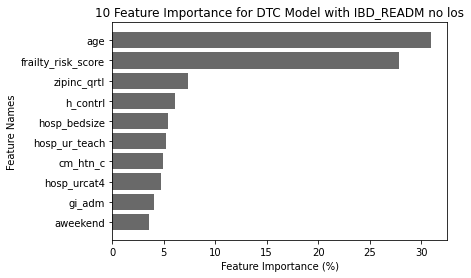

In [116]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for DTC Model with IBD_READM no los')
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_no_los_Feature_Importance_10')
plt.show()

## XGBoost Classifier Model <a class="anchor" id="xgboostrfe"></a> 

## Target: HNHC <a class="anchor" id="xgbhnhc"></a>

[Return to Table of Contents](#contents)

In [117]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

tric if you'd like to restore the old behavior.
[18:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:21:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:21:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:21:56] WARNING: C:

In [118]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,hnhc_patients,steroid_use,los,orproc,payer,cm_depress,cm_dmcx,cm_drug,cc_index,thromboses,chronic_pain
0,0,0,4,0,1.0,0,0,0,2,0,0
3,0,0,4,1,2.0,0,0,0,0,0,0
4,1,0,5,0,1.0,0,0,0,0,0,0
9,0,0,3,1,2.0,0,0,0,0,0,0
10,0,0,6,1,1.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,0,3,0,2.0,0,0,0,0,0,0
94492,0,0,4,1,2.0,0,0,0,0,0,0
94493,1,0,9,1,2.0,0,0,0,0,0,0
94496,0,0,2,1,1.0,1,0,0,2,0,0


In [119]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47349, dtype: int64

In [120]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['steroid_use', 'los', 'orproc', 'payer', 'cm_depress', 'cm_dmcx',
       'cm_drug', 'cc_index', 'thromboses', 'chronic_pain'],
      dtype='object')

In [121]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[18:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.9236856185407338
Testing Score: 0.91628653488765


In [122]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

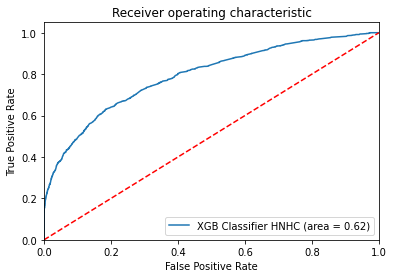

In [123]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier HNHC (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_HNHC_ROC_10')
plt.show()

In [124]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[18:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

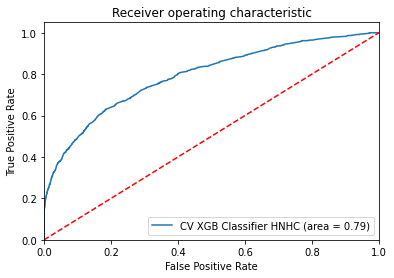

In [125]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier HNHC (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_HNHC_ROC_10')
plt.show()

In [126]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.05064317, 'cm_depress'),
 (0.051480174, 'cc_index'),
 (0.05214356, 'thromboses'),
 (0.053440712, 'cm_dmcx'),
 (0.0613714, 'steroid_use'),
 (0.06320968, 'chronic_pain'),
 (0.064165704, 'payer'),
 (0.06558367, 'cm_drug'),
 (0.104372695, 'orproc'),
 (0.43358922, 'los')]

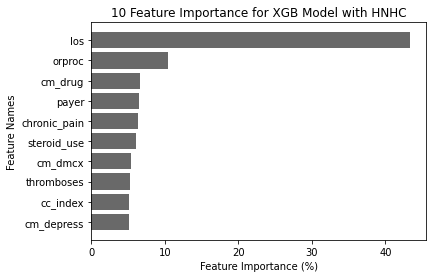

In [127]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for XGB Model with HNHC')
plt.savefig('images\XGB_Classifier_HNHC_Feature_Importance_10')
plt.show()

## Target: HNHC no 'los' <a class="anchor" id="xgbhnhcnolos"></a>

[Return to Table of Contents](#contents)

In [128]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc_no_los, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

the old behavior.
[18:24:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:24:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:24:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:24:46] WARNING: C:/Users/Administrator/workspace

In [129]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,hnhc_patients,orproc,payer,severe_IBD_hospitalization,cm_dmcx,cm_drug,cm_wghtloss,blood_transfusion,cc_index,thromboses,chronic_pain
0,0,0,1.0,0,0,0,0,0,2,0,0
3,0,1,2.0,0,0,0,0,0,0,0,0
4,1,0,1.0,0,0,0,0,0,0,0,0
9,0,1,2.0,0,0,0,0,0,0,0,0
10,0,1,1.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,0,2.0,0,0,0,0,0,0,0,0
94492,0,1,2.0,0,0,0,0,0,0,0,0
94493,1,1,2.0,1,0,0,0,1,0,0,0
94496,0,1,1.0,0,0,0,0,0,2,0,0


In [130]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47349, dtype: int64

In [131]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['orproc', 'payer', 'severe_IBD_hospitalization', 'cm_dmcx', 'cm_drug',
       'cm_wghtloss', 'blood_transfusion', 'cc_index', 'thromboses',
       'chronic_pain'],
      dtype='object')

In [132]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[18:26:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.9052406296640477
Testing Score: 0.9026017908430478


In [133]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

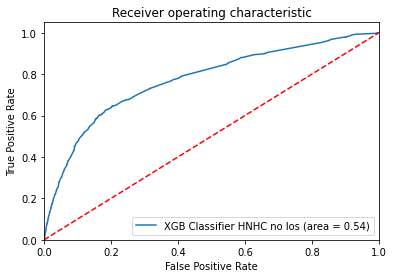

In [134]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier HNHC no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_HNHC_no_los_ROC_10')
plt.show()

In [135]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[18:26:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:26:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:26:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:26:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

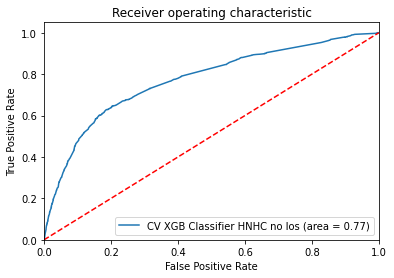

In [136]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier HNHC no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_HNHC_no_los_ROC_10')
plt.show()

In [137]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.025838211, 'cm_dmcx'),
 (0.02596931, 'cc_index'),
 (0.026314372, 'cm_drug'),
 (0.028369302, 'chronic_pain'),
 (0.029798282, 'thromboses'),
 (0.030048203, 'payer'),
 (0.033495214, 'orproc'),
 (0.03725936, 'cm_wghtloss'),
 (0.04071098, 'blood_transfusion'),
 (0.7221968, 'severe_IBD_hospitalization')]

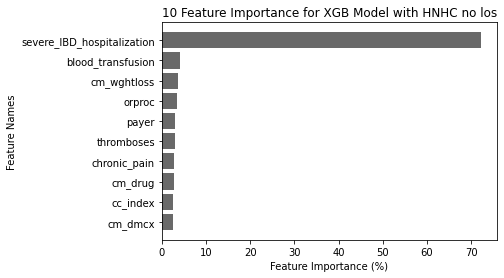

In [138]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for XGB Model with HNHC no los')
plt.savefig('images\XGB_Classifier_HNHC_no_los_Feature_Importance_10')
plt.show()

## Target: IBD_READM <a class="anchor" id="xgbreadm"></a>

[Return to Table of Contents](#contents)

In [139]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

 to restore the old behavior.
[18:27:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:54] WARNING: C:/Users/Administrat

In [140]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,ibd_readm,steroid_use,elective,orproc,payer,cm_drug,ibd_procedures,cc_index,thromboses,chronic_pain,ibd_specific_adm
0,1,0,0.0,0,1.0,0,0,2,0,0,0
3,0,0,1.0,1,2.0,0,1,0,0,0,1
4,1,0,0.0,0,1.0,0,0,0,0,0,1
9,0,0,0.0,1,2.0,0,0,0,0,0,0
10,0,0,1.0,1,1.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,0,0.0,0,2.0,0,0,0,0,0,0
94492,0,0,1.0,1,2.0,0,1,0,0,0,0
94493,1,0,1.0,1,2.0,0,1,0,0,0,1
94496,0,0,1.0,1,1.0,0,0,2,0,0,0


In [141]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47303, dtype: int64

In [142]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['steroid_use', 'elective', 'orproc', 'payer', 'cm_drug',
       'ibd_procedures', 'cc_index', 'thromboses', 'chronic_pain',
       'ibd_specific_adm'],
      dtype='object')

In [143]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[18:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.6187670885362347
Testing Score: 0.6018941315744969


In [144]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

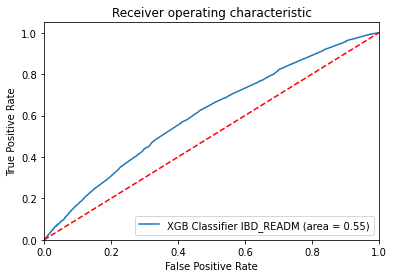

In [145]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier IBD_READM (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_IBD_READM_ROC_10')
plt.show()

In [146]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[18:29:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

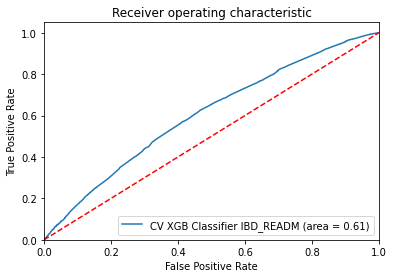

In [147]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier IBD_READM (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_IBD_READM_ROC_10')
plt.show()

In [148]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.06958397, 'cc_index'),
 (0.07957197, 'chronic_pain'),
 (0.08268576, 'thromboses'),
 (0.08834871, 'steroid_use'),
 (0.08936152, 'elective'),
 (0.09210643, 'cm_drug'),
 (0.10530857, 'ibd_procedures'),
 (0.10711137, 'ibd_specific_adm'),
 (0.120929874, 'orproc'),
 (0.16499181, 'payer')]

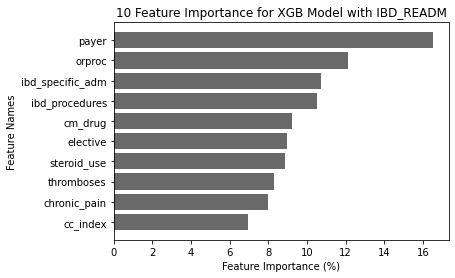

In [149]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for XGB Model with IBD_READM')
plt.savefig('images\XGB_Classifier_IBD_READM_Feature_Importance_10')
plt.show()

## Target: IBD_READM no 'los' <a class="anchor" id="xgbreadmnolos"></a>

[Return to Table of Contents](#contents)

In [150]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=10)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit_no_los, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

d behavior.
[18:30:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:56] WARNING: C:/Users/Administrator/workspace/xgboo

In [151]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

,ibd_readm,steroid_use,elective,orproc,payer,severe_IBD_hospitalization,cm_anemdef,cm_drug,ibd_procedures,chronic_pain,ibd_specific_adm
0,1,0,0.0,0,1.0,0,1,0,0,0,0
3,0,0,1.0,1,2.0,0,0,0,1,0,1
4,1,0,0.0,0,1.0,0,1,0,0,0,1
9,0,0,0.0,1,2.0,0,0,0,0,0,0
10,0,0,1.0,1,1.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94491,0,0,0.0,0,2.0,0,0,0,0,0,0
94492,0,0,1.0,1,2.0,0,0,0,1,0,0
94493,1,0,1.0,1,2.0,1,0,0,1,0,1
94496,0,0,1.0,1,1.0,0,0,0,0,0,0


In [152]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47303, dtype: int64

In [153]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['steroid_use', 'elective', 'orproc', 'payer',
       'severe_IBD_hospitalization', 'cm_anemdef', 'cm_drug', 'ibd_procedures',
       'chronic_pain', 'ibd_specific_adm'],
      dtype='object')

In [154]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[18:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.6133269442173803
Testing Score: 0.5991036698799256


In [155]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

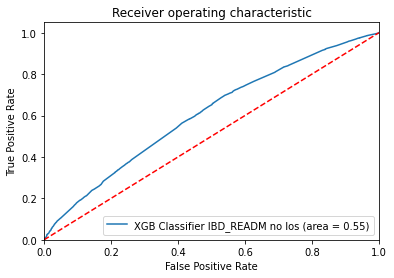

In [156]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier IBD_READM no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_IBD_READM_no_los_ROC_10')
plt.show()

In [157]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[18:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

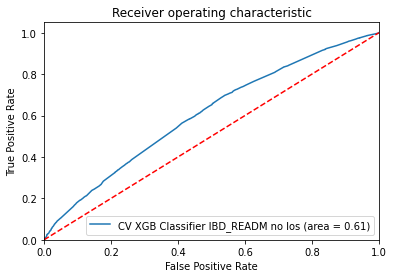

In [158]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier IBD_READM no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_IBD_READM_no_los_ROC_10')
plt.show()

In [159]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.05126513, 'ibd_specific_adm'),
 (0.056900807, 'elective'),
 (0.05733064, 'cm_drug'),
 (0.060319908, 'chronic_pain'),
 (0.07878221, 'steroid_use'),
 (0.0869148, 'cm_anemdef'),
 (0.09692559, 'ibd_procedures'),
 (0.1530203, 'orproc'),
 (0.17912121, 'severe_IBD_hospitalization'),
 (0.17941947, 'payer')]

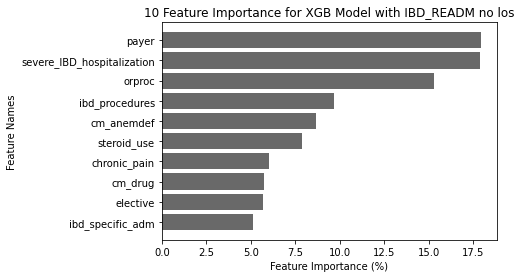

In [160]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for XGB Model with IBD_READM no los')
plt.savefig('images\XGB_Classifier_IBD_READM_no_los_Feature_Importance_10')
plt.show()